# Part I

I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [115]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [12]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [21]:
dat[:,(0,2)]

array([[8.800e-03, 3.810e+02],
       [7.800e-03, 5.590e+02],
       [1.200e-03, 3.690e+02],
       ...,
       [9.876e-01, 2.631e+03],
       [3.060e-02, 7.050e+02],
       [8.898e-01, 1.044e+03]])

In [48]:
from sklearn.model_selection import train_test_split
# 85/15 split - creating a training data set of only (Xl, al) - no gamma
temp = train_test_split(np.log(dat[:,(0,2)]), test_size=0.15, random_state=42)

train_data = temp[0][:,0]
train_labs = temp[0][:,1]
test_data = temp[1][:,0]
test_labs = temp[1][:,1]

In [16]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [91]:
intermediate_dim = 1024
latent_dim = 32
batch_size = 512
epsilon_std = 1.0
sigma2sq = np.sqrt(20.0).astype('float32')

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

# when z (i.e., \gamma) ~ N(\mu_2=0, \sigma_2) - can only do one latent dimension
# class KLDivergenceLayer(Layer):
#     """ Identity transform layer that adds KL divergence to the final model loss.
#     """
#     def __init__(self, *args, **kwargs):
#         self.is_placeholder = True
#         super(KLDivergenceLayer, self).__init__(*args, **kwargs)

#     def call(self, inputs):
#         mu, log_var = inputs
#         kl_batch = keras.backend.log(sigma2sq) - log_var + .5 * (keras.backend.exp(log_var) + keras.backend.square(mu))/sigma2sq - .5

#         self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
#         return inputs

# when z ~ N(0, 1) - but can do multiple dimensions i.e., MVN(0, I)
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 1 dim - Xl
x = keras.Input(shape=(1,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(512, activation='relu')(x)
h = Dense(256, activation='relu')(h)

gamma_mu = Dense(latent_dim)(h)
gamma_log_var = Dense(latent_dim)(h)

gamma_mu, gamma_log_var = KLDivergenceLayer()([gamma_mu, gamma_log_var])
gamma_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(gamma_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
gamma_eps = Multiply()([gamma_sigma, eps])
gamma = Add()([gamma_mu, gamma_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(256, input_dim=latent_dim, activation='relu'), 
    Dense(512, input_dim=256, activation='relu'),
    Dense(intermediate_dim, input_dim=512, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(gamma)
# symbolic representation
encoder = keras.Model(x, outputs=[gamma_mu, gamma_sigma])

In [92]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.................................................................

In [93]:
gamma_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(gamma_preds[0])))

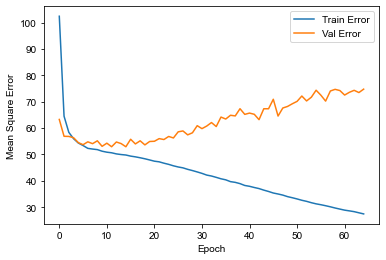

In [94]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

(array([[   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 2031., 5469.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 1499., 6001.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [1447.,  654.,  877.,  768.,  787.,  834.,  634.,  688.,  262.,
          549.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.

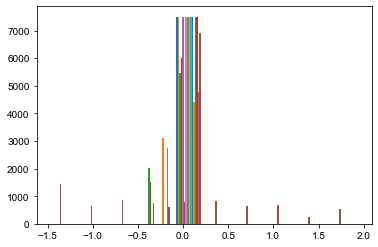

In [80]:
plt.hist(gamma_preds[0])

Text(40000, 2500, 'Intercept = 5488.94')

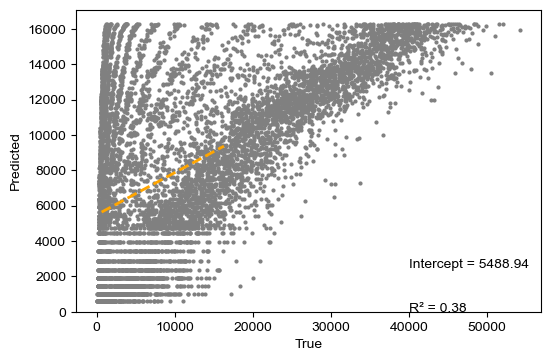

In [95]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
plt.ylim(0)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 10, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

# Part II

Below, I will ask the BaselineNet to learn the parameters of a $N(\mu, \sigma^2=0.25)$ since the $\log(a_l)$ is distributed normally, compared to the raw allele ages that are $\Gamma$ distributed. 

In [101]:
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]
temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# for each gamma value...
Xltrain = []
Xltest = []
altrain = []
altest = []
for t in np.arange(len(temp)):
    Xltrain.append(temp[t][0])
    Xltest.append(temp[t][1])
    altrain.append(temp[t][2])
    altest.append(temp[t][3])

train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs = np.log(np.hstack(altrain[0:50]))

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.log(np.hstack(altest[0:50]))

In [375]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs = np.log(np.hstack(altrain[0:50]))

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.log(np.hstack(altest[0:50]))

In [376]:
x = keras.Input(shape=(2,))
h = Dense(512, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(256, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(128, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(64, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(16, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, activation='relu', kernel_initializer='random_uniform')(h)

#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(tf.math.softplus(t[:,0]), tf.math.softplus(t[:,1])))(params)

## having just 1 free parameters works well...
#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t), 0.25))(params)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(t[:,0], t[:,1]))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -p_y.log_prob(y)

param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

(array([  25.,   97.,  234.,  505.,  595.,  766.,  882., 1310., 1728.,
        1358.]),
 array([ 4.07753744,  4.76051499,  5.44349253,  6.12647007,  6.80944761,
         7.49242515,  8.17540269,  8.85838023,  9.54135778, 10.22433532,
        10.90731286]),
 <BarContainer object of 10 artists>)

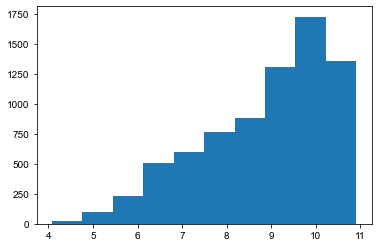

In [253]:
plt.hist(test_labs)

In [372]:
prob_model.fit(train_data, train_labs, epochs=2, shuffle=True)

Epoch 1/2
1329/1329 [==============================] - 3s 2ms/step - loss: 25241573.6323
Epoch 2/2
1329/1329 [==============================] - 2s 2ms/step - loss: 31.4025


In [377]:
history = prob_model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................

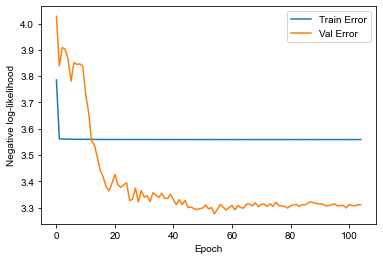

In [326]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [378]:
pred_params = param_model.predict(test_data)
pred_params

array([[0.      , 8.295468],
       [0.      , 8.295468],
       [0.      , 8.295468],
       ...,
       [0.      , 7.905265],
       [0.      , 8.364109],
       [0.      , 8.332955]], dtype=float32)

(array([  11.,   22.,   29.,   25.,   19.,   28.,  358.,  298., 1665.,
        5045.]),
 array([2108.7378, 2331.422 , 2554.1064, 2776.7908, 2999.475 , 3222.1594,
        3444.8438, 3667.528 , 3890.2124, 4112.8965, 4335.581 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

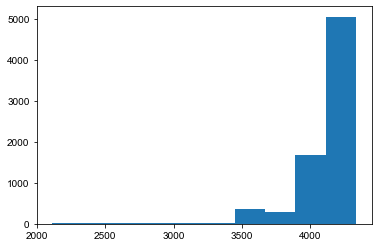

In [379]:
plt.hist(np.exp(pred_params[:,1]))

In [347]:
preds = np.exp(np.ravel(pred_params[:,0]))

(array([2424., 1028.,  713.,  584.,  528.,  477.,  414.,  426.,  409.,
         497.]),
 array([   76.94464,  4863.1294 ,  9649.314  , 14435.499  , 19221.684  ,
        24007.87   , 28794.053  , 33580.24   , 38366.42   , 43152.61   ,
        47938.793  ], dtype=float32),
 <BarContainer object of 10 artists>)

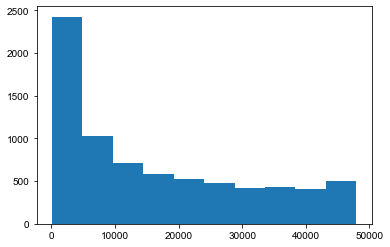

In [312]:
plt.hist(np.exp(pred_params[:,1]))

In [270]:
plt.hist(np.exp(np.ravel(test_labs)))

ValueError: supplied range of [1.0000000000004376, inf] is not finite

Text(40000, 2500, 'Intercept = 6798.41')

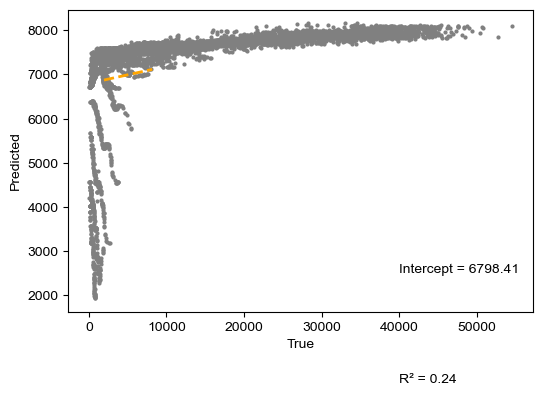

In [348]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [344]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = np.exp(pred_params[i,0] - 1.96*0.25), np.exp(pred_params[i,0] + 1.96*0.25)
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

Accuracy: 93.64%


(array([  64.,  170.,  284.,  401.,  473.,  642.,  907., 1082., 1375.,
        2102.]),
 array([ 4.3430862,  4.9865456,  5.630005 ,  6.2734647,  6.916924 ,
         7.5603833,  8.203843 ,  8.847302 ,  9.490762 , 10.134221 ,
        10.77768  ], dtype=float32),
 <BarContainer object of 10 artists>)

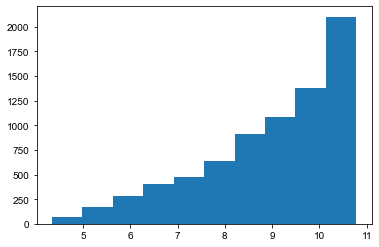

In [311]:
plt.hist(pred_params[:,1])

# Part III

Below, I will model the allele ages as coming from a $\Gamma(\alpha, \beta) = x^{\alpha - 1} e^{-x \beta} \beta^{\alpha}/ \Gamma(\alpha)$ distribution given $X_l$ and $\gamma$. The loss function needs to be defined as a negative log-likelihood of the $\Gamma$ distribution...

In [381]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs =np.hstack(altrain[0:50])

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

In [382]:
x = keras.Input(shape=(2,))
h = Dense(512, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(256, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(128, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, activation='relu', kernel_initializer='random_uniform')(h)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(t[:,0], t[:,1]))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -p_y.log_prob(y)

param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [383]:
history = prob_model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.........................................................

In [384]:
pred_params = param_model.predict(test_data)
pred_params

array([[0.40437254, 0.        ],
       [0.4048008 , 0.        ],
       [0.40436193, 0.        ],
       ...,
       [0.26617712, 0.        ],
       [0.2852771 , 0.        ],
       [0.28171968, 0.        ]], dtype=float32)

Text(40000, 2500, 'Intercept = 4876.87')

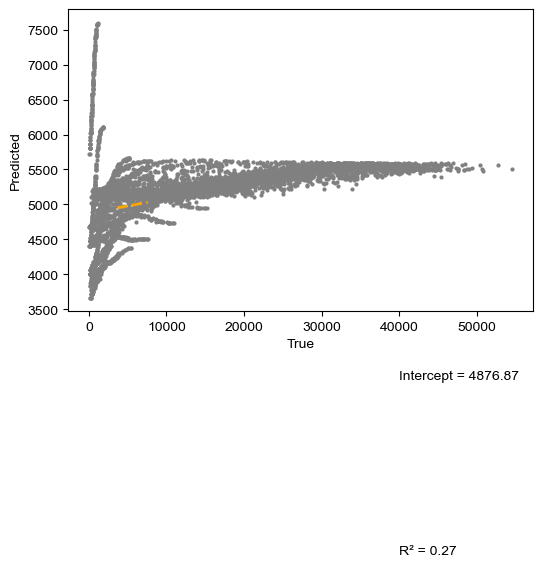

In [370]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(test_labs, pred_params[:,0], 'o', color='grey', markersize=2)
res = sm.OLS(pred_params[:,0], sm.add_constant(test_labs)).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(pred_params[:,0]), np.max(pred_params[:,0]), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))